In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16719176934132220007
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6046938942244611859
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3577029438145398512
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11150664704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2552118631239416034
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

import torch
import torchvision
import torchvision.transforms as transforms


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [4]:
# !wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

In [5]:
# !unzip glove*.zip -d '/content/gdrive/My Drive/twitter misinfo/'

In [6]:
seed = 100

torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [7]:
real = pd.read_csv('/content/gdrive/My Drive/twitter misinfo/2020_04_10000_real_tweets.csv', header = None)
fake = pd.read_csv('/content/gdrive/My Drive/twitter misinfo/2020_04_10000_fake_tweets_unconditional.csv', header = None)


In [8]:
real.columns = ['tweet']

In [9]:
# real['index'] = real.index

In [10]:
fake.columns = ['tweet']
# fake['index'] = fake.index

In [11]:
cols = real.columns.tolist()
cols = cols[-1:] + cols[:-1]

In [12]:
real = real[cols]

In [13]:
cols = fake.columns.tolist()
cols = cols[-1:] + cols[:-1]
fake = fake[cols]

In [14]:
real['label'] = 1
fake['label'] = 0
real.head()

,tweet,label
0,#Taiwan isn't a member of the #WHO. Taiwan tr...,1
1,From the DJs to the CJs.. Look whose in the PJ...,1
2,The @ClinicalBioinfo led by @xdopazo releases ...,1
3,IMF expects #Greece to be the worst hit econom...,1
4,More on #COVID19 - China witnessed a slight in...,1


In [15]:
fake.head()

,tweet,label
0,@chrislhayes I think it's important to note th...,0
1,"The problem is, it's the Chinese that are bein...",0
2,Do you know of any people who are looking for ...,0
3,Just as the COVID-19 pandemic has shown that t...,0
4,Covid-19's impact on the economy: The RBC Stat...,0


In [16]:
fake['tweet'][0]

"@chrislhayes I think it's important to note that there are two big areas that need to be addressed. First, the coronavirus and the existing system. Second, the existing system and health systems.  The first is very, very important, and that's a big concern. "

In [17]:
combined = pd.concat([fake, real])
features = combined['tweet']
labels = combined['label']
combined = combined.sample(frac = 1).reset_index(drop = True)
# combined['index'] = combined.index
combined.tail()
combined.isna().sum()
combined.dropna(axis = 0)

,tweet,label
0,"""The manual covers setting up: -screening &amp...",1
1,Can anyone confirm this??,0
2,Take the name Rajdeep. It's @ABPNews and I dar...,1
3,I've been wondering what they will do in the f...,0
4,Compulsory to wear a mask now when you step ou...,1
...,...,...
19992,What is the difference between the #CoronaViru...,0
19993,Local churches file lawsuit to conduct religio...,1
19994,"After the pandemic, it is increasingly hard to...",0
19995,Good morning everyone! I wanted to share with ...,0


In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

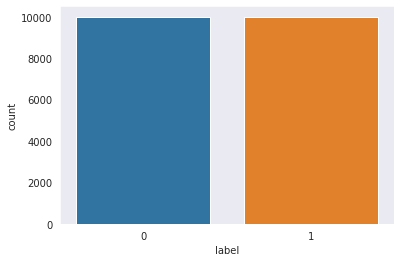

In [19]:
sns.set_style("dark")
sns.countplot(combined.label)

In [20]:
# combined['tweet'] = combined['tweet'].astype(str).str.replace('[^a-zA-Z]',' ').str.lower()
# combined.to_csv('/content/gdrive/My Drive/twitter misinfo/combined.csv', sep='\t', index=False)

In [21]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [22]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(str(text))
    text = remove_between_square_brackets(str(text))
    text = remove_stopwords(str(text))
    return text
#Apply function on review column
combined['tweet']=combined['tweet'].apply(denoise_text)

In [23]:
combined.to_csv('/content/gdrive/My Drive/twitter misinfo/combined.csv', sep='\t', index=False)

In [24]:
# plt.figure(figsize = (20,20)) # Text that is not Fake
# wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(combined[combined.label == 1].tweet))
# plt.imshow(wc , interpolation = 'bilinear')

In [25]:
# plt.figure(figsize = (20,20)) # Text that is not Fake
# wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(combined[combined.label == 0].tweet))
# plt.imshow(wc , interpolation = 'bilinear')

In [26]:
# x_train,x_test,y_train,y_test = train_test_split(combined.tweet,combined.category,random_state = 0)

In [27]:
from torchtext import data

TWEET = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.int,batch_first=True)

fields = [('tweet', TWEET), ('label', LABEL)]

In [28]:
training_data=data.TabularDataset(path = '/content/gdrive/My Drive/twitter misinfo/combined.csv', format = 'tsv', fields = fields, skip_header=True)

In [71]:
print(vars(training_data[0]))
training_data.examples[0].label

{'tweet': ['"', 'The', 'manual', 'covers', 'setting', 'up', ':', '-screening', 'triage', 'health', 'facilities', ',', 'using', 'repurposed', 'building', 'tent', '-community', 'facilities', 'care', 'mild', 'patients', '-a', 'treatment', 'centre', ',', 'repurposing', 'hospital', 'wards', 'entire', '🏥', ',', 'setting', 'new', '🏥', 'tent"-@DrTedros'], 'label': '1'}


'1'

In [30]:
# import numpy as np

# measurer = np.vectorize(len)

# res1 = measurer(combined.values.astype(str)).max(axis=0)
# res2 = measurer(combined.values.astype(str)).min(axis=0)
# print(res1, "\n", res2)
import random
train_data, valid_data = training_data.split(split_ratio=0.7, random_state = random.seed(seed))

train_data

In [31]:
pip install -U bcolz

     |████████████████████████████████| 1.5MB 2.8MB/s 
  Created wheel for bcolz: filename=bcolz-1.2.1-cp36-cp36m-linux_x86_64.whl size=2667398 sha256=e4691b4aa9846fb629fb90acdd78543cba667629cc97e24fb11443b24bb9077b
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz


In [32]:
# max_features = 10000
# maxlen = 520

#initialize glove embeddings

# EMBEDDING_FILE = '/content/gdrive/My Drive/twitter misinfo/glove.twitter.27B.200d.txt'


# import bcolz

# words = []
# idx = 0
# word2idx = {}
# vectors = bcolz.carray(np.zeros(1), rootdir=f'/content/gdrive/My Drive/twitter misinfo/glove.twitter.27B.200d.dat', mode='w')

# with open(f'/content/gdrive/My Drive/twitter misinfo/glove.twitter.27B.200d.txt', 'rb') as f:
#     for l in f:
#         line = l.decode().split()
#         word = line[0]
#         words.append(word)
#         word2idx[word] = idx
#         idx += 1
#         vect = np.array(line[1:]).astype(np.float)
#         vectors.append(vect)

TWEET.build_vocab(train_data,min_freq=3,vectors = 'glove.twitter.27B.200d')  
LABEL.build_vocab(train_data)

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TWEET.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TWEET.vocab.freqs.most_common(10))  

#Word dictionary
print(TWEET.vocab.stoi)

.vector_cache/glove.twitter.27B.zip: 1.52GB [11:43, 2.16MB/s]                            
100%|█████████▉| 1192506/1193514 [01:51<00:00, 10775.64it/s]

Size of TEXT vocabulary: 8391
Size of LABEL vocabulary: 2
[('.', 18563), ('#', 18058), (',', 11115), ('COVID19', 3622), (':', 3220), ('coronavirus', 2859), ('?', 1995), ('!', 1866), ('"', 1657), ('’s', 1638)]
defaultdict(<function _default_unk_index at 0x7fa44afb2268>, {'<unk>': 0, '<pad>': 1, '.': 2, '#': 3, ',': 4, 'COVID19': 5, ':': 6, 'coronavirus': 7, '?': 8, '!': 9, '"': 10, '’s': 11, 'pandemic': 12, '-': 13, 'COVID-19': 14, 'people': 15, 'I': 16, "'s": 17, 'Coronavirus': 18, 'virus': 19, 'home': 20, 'cases': 21, 'China': 22, 'lockdown': 23, 'stay': 24, 'it': 25, 'need': 26, '”': 27, '“': 28, 'us': 29, 'world': 30, 'time': 31, 'n’t': 32, 'help': 33, 'deaths': 34, 'get': 35, 'new': 36, ')': 37, "'": 38, 'one': 39, '(': 40, 'know': 41, 'US': 42, 'crisis': 43, 'country': 44, 'going': 45, '...': 46, 'like': 47, 'health': 48, '’m': 49, 'safe': 50, "'m": 51, '’re': 52, 'work': 53, 'death': 54, 'Please': 55, 'patients': 56, 'make': 57, 'number': 58, 'still': 59, 'go': 60, 'see': 61, 'ma

In [33]:
# tokenizer = text.Tokenizer(num_words=max_features)
# tokenizer.fit_on_texts(x_train)
# tokenized_train = tokenizer.texts_to_sequences(x_train)
# x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

#set batch size
BATCH_SIZE = 256

#Load an iterator
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.tweet),
    sort_within_batch=True,
    device = device)

In [62]:
# #Defining Neural Network
# model = Sequential()
# #Non-trainable embeddidng layer
# model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
# #LSTM 
# model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
# model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
# model.add(Dense(units = 32 , activation = 'relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])


import torch.nn as nn

class classifier(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim_1, hidden_dim_2, output_dim, n_layers, bidirectional, dropout):
        
        #Constructor
        super().__init__()          
        
        #embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm layer
        self.lstm1 = nn.LSTM(embedding_dim, 
                           hidden_dim_1, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=0.25,
                           batch_first=True)
        
        self.lstm2 = nn.LSTM(hidden_dim_1,
                           hidden_dim_2, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=0.1)
        
    # self.lstm_1 = nn.LSTM(self.nb_features, self.hidden_size_1, self.nb_layers_1, dropout=dropout)  
    # self.lstm_2 = nn.LSTM(self.hidden_size_1, self.hidden_size_2, self.nb_layers_2, dropout=dropout)
        
        #dense layer

        # self.fc - nn.Linear(hidden_dim_2, 64)
        self.fc1 = nn.Linear(hidden_dim_2, 32)
        
        self. fc2 = nn.Linear(32, 1)

        #activation function
        self.act = nn.Sigmoid()
        
    def forward(self, tweet):
        
        #text = [batch size,sent_length]
        # x = torch.FloatTensor(x)
        embedded = torch.FloatTensor(self.embedding(tweet))
        # flat_embedded = flattened = [item for sublist in embedded for item in sublist]
        #embedded = [batch size, sent_len, emb dim]
      
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, embedding_dim, batch_first=True)
        
        packed_output_1, (hidden_1, cell_1) = self.lstm1(packed_embedded)

        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output_1, batch_first=True)
        # print(output.shape()) 
        packed_output_2, (hidden_2, cell_2) = self.lstm2(output)



        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
        
        #concat the final forward and backward hidden state
        hidden = torch.cat((hidden_2[-2,:,:], hidden_2[-1,:,:]), dim = 1)
                
        #hidden = [batch size, hid dim * num directions]
        dense_outputs=torch.nn.functional.relu(self.fc1(hidden))

        #Final activation function

        outputs = torch.nn.functional.sigmoid(self.fc2(dense_outputs))
        # outputs=self.act(dense_outputs)
        
        return outputs

# max_features = 10000
# maxlen = 520

In [63]:
# EMBEDDING_FILE = '/content/gdrive/My Drive/twitter misinfo/glove.twitter.27B.200d.txt'

#define hyperparameters
size_of_vocab = len(TWEET.vocab)
embedding_dim = 200
# num_hidden_nodes = 32
hidden_dim_1 = 128
hidden_dim_2 = 64
num_output_nodes = 1
num_layers = 2
bidirection = True
dropout = 0.2

#instantiate the model
model = classifier(size_of_vocab, embedding_dim, hidden_dim_1, hidden_dim_2, num_output_nodes, num_layers, bidirectional = True, dropout = dropout)

In [64]:
# def get_coefs(word, *arr): 
#     return word, np.asarray(arr, dtype='float32')
# embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

#architecture
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

#Initialize the pretrained embedding
pretrained_embeddings = TWEET.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

print(pretrained_embeddings.shape)

classifier(
  (embedding): Embedding(8391, 200)
  (lstm1): LSTM(200, 128, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (lstm2): LSTM(128, 64, num_layers=2, dropout=0.1, bidirectional=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (act): Sigmoid()
)
The model has 2,612,153 trainable parameters
torch.Size([8391, 200])


In [65]:
# all_embs = np.stack(embeddings_index.values())
# emb_mean,emb_std = all_embs.mean(), all_embs.std()
# embed_size = all_embs.shape[1]

# word_index = tokenizer.word_index
# nb_words = min(max_features, len(word_index))
# #change below line if computing normal stats is too slow
# embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
# for word, i in word_index.items():
#     if i >= max_features: continue
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None: embedding_matrix[i] = embedding_vector

import torch.optim as optim

#define optimizer and loss
# torch.optim.lr_scheduler.ReduceLROnPlateau()
optimizer = optim.Adam(model.parameters())
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=1, factor=0.5, min_lr=0.00001)
criterion = nn.BCELoss()

#define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
#push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [66]:
# batch_size = 256
# epochs = 10
# embed_size = 200

def train(model, iterator, optimizer, criterion):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words
        tweet = batch.tweet   
        
        #convert to 1D tensor
        # predictions = model(tweet, tweet_lengths).squeeze() 

        predictions = model(tweet).squeeze()  
 
        
        #compute the loss
        loss = criterion(predictions, batch.label)        
        
        #compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        #backpropage the loss and compute the gradients
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [67]:
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

def evaluate(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            #retrieve text and no. of words
            tweet = batch.tweet
            
            #convert to 1d tensor
            predictions = model(tweet).squeeze()
            
            #compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [68]:
# #Defining Neural Network
# model = Sequential()
# #Non-trainable embeddidng layer
# model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
# #LSTM 
# model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
# model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
# model.add(Dense(units = 32 , activation = 'relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

N_EPOCHS =  10
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
     
    #train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    #evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

TypeError: ignored

In [ ]:
# model.summary()

#load weights
path='/content/saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();

#inference 
import spacy
nlp = spacy.load('en')

def predict(model, sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  #tokenize the sentence 
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]          #convert to integer sequence
    length = [len(indexed)]                                    #compute no. of words
    tensor = torch.LongTensor(indexed).to(device)              #convert to tensor
    tensor = tensor.unsqueeze(1).T                             #reshape in form of batch,no. of words
    length_tensor = torch.LongTensor(length)                   #convert to tensor
    prediction = model(tensor, length_tensor)                  #prediction 
    return prediction.item() 

In [ ]:
# history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs , callbacks = [learning_rate_reduction])

#make predictions
predict(model, "Are there any sports that you don't like?")

#insincere question
predict(model, "Why Indian girls go crazy about marrying Shri. Rahul Gandhi ji?")

In [ ]:
# print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
# print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

In [ ]:
# epochs = [i for i in range(10)]
# fig , ax = plt.subplots(1,2)
# train_acc = history.history['accuracy']
# train_loss = history.history['loss']
# val_acc = history.history['val_accuracy']
# val_loss = history.history['val_loss']
# fig.set_size_inches(20,10)

# ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
# ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
# ax[0].set_title('Training & Testing Accuracy')
# ax[0].legend()
# ax[0].set_xlabel("Epochs")
# ax[0].set_ylabel("Accuracy")

# ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
# ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
# ax[1].set_title('Training & Testing Loss')
# ax[1].legend()
# ax[1].set_xlabel("Epochs")
# ax[1].set_ylabel("Loss")
# plt.show()

In [ ]:
# pred = model.predict_classes(X_test)
# pred[:5]

In [ ]:
# print(classification_report(y_test, pred, target_names = ['Fake','Not Fake']))

In [ ]:
# cm = confusion_matrix(y_test,pred)
# cm

In [ ]:
# cm = pd.DataFrame(cm , index = ['Fake','Not Fake'] , columns = ['Fake','Not Fake'])

In [ ]:
# plt.figure(figsize = (10,10))
# sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Not Fake'] , yticklabels = ['Fake','Not Fake'])
# plt.xlabel("Actual")
# plt.ylabel("Predicted")